In [1]:
import spikeinterface as si
import spikeinterface.extractors as se
import numpy as np
import json
from pathlib import Path
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt

In [2]:
%matplotlib widget

In [3]:
raw_asset_folder = Path("../data/ecephys_753126_2024-10-15_12-20-35/")

In [4]:
raw_recording = si.read_zarr("../data/ecephys_753126_2024-10-11_13-14-24/ecephys/ecephys_compressed/experiment1_Record Node 103#Neuropix-PXI-100.ProbeA.zarr/")

In [5]:
si.set_global_job_kwargs(n_jobs=-1, chunk_duration="1s")
job_kwargs = si.get_global_job_kwargs()

## Find max absolute values

In [6]:
# use SI job tools for blocks!
def get_recording_min_max(recording: si.BaseRecording, return_scaled=False, verbose=False, **job_kwargs):
    """
    Parameters
    ----------
    recording : si.BaseRecording
        The input recording
    output_folder : _type_
        The folder where the compressed data is saved
    """
    from spikeinterface.core.job_tools import ensure_n_jobs, ChunkRecordingExecutor, fix_job_kwargs

    job_kwargs = fix_job_kwargs(job_kwargs)
    # use executor (loop or workers)
    func = _compute_ptp_chunk
    init_func = _init_ptp_worker
    init_args = (recording, return_scaled)

    executor = ChunkRecordingExecutor(recording, func, init_func, init_args, verbose=verbose,
                                      handle_returns=True, job_name='compute_ptp', **job_kwargs)
    min_maxs = executor.run()
    min_maxs = np.array(min_maxs)

    min_global = np.min(min_maxs[:, 0])
    max_global = np.max(min_maxs[:, 1])
    
    return min_global, max_global
    

# used by write_binary_recording + ChunkRecordingExecutor
def _init_ptp_worker(recording, return_scaled):
    # create a local dict per worker
    worker_ctx = {}
    worker_ctx['recording'] = recording
    worker_ctx['return_scaled'] = return_scaled
    
    return worker_ctx


# used by write_binary_recording + ChunkRecordingExecutor
def _compute_ptp_chunk(segment_index, start_frame, end_frame, worker_ctx):
    # recover variables of the worker
    recording = worker_ctx['recording']
    return_scaled = worker_ctx['return_scaled'] 
    traces = recording.get_traces(segment_index=segment_index, start_frame=start_frame,
                                  end_frame=end_frame, return_scaled=return_scaled)
    
    return [np.min(traces), np.max(traces)]

In [7]:
abs_min, abs_max = get_recording_min_max(raw_recording, return_scaled=False)

compute_ptp:   0%|          | 0/4855 [00:00<?, ?it/s]

In [52]:
print(abs_min, abs_max)
print(abs_min * raw_recording.get_channel_gains()[0], abs_max * raw_recording.get_channel_gains()[0])

-2184 2184
-6388.1997641279995 6388.1997641279995


In [53]:
raw_recording._annotations

{'is_filtered': False,
 'probe_0_planar_contour': [[-11, 9989],
  [-11, -11],
  [24, -186],
  [59, -11],
  [59, 9989],
  [239, 9989],
  [239, -11],
  [274, -186],
  [309, -11],
  [309, 9989],
  [489, 9989],
  [489, -11],
  [524, -186],
  [559, -11],
  [559, 9989],
  [739, 9989],
  [739, -11],
  [774, -186],
  [809, -11],
  [809, 9989]],
 'probes_info': [{'dock': '2',
   'manufacturer': 'IMEC',
   'model_name': 'Neuropixels 2.0 - Four Shank',
   'name': 'ProbeA',
   'part_number': 'NP2014',
   'port': '2',
   'serial_number': '22420011054',
   'slot': '2'}],
 'compression_ratio': 3.6226467911800615,
 'compression_ratio_segments': {0: 3.6226467911800615}}

## Saturation events

In [8]:
raw_recording.get_annotation("probes_info")[0]

{'dock': '2',
 'manufacturer': 'IMEC',
 'model_name': 'Neuropixels 2.0 - Four Shank',
 'name': 'ProbeA',
 'part_number': 'NP2014',
 'port': '2',
 'serial_number': '22420011054',
 'slot': '2'}

In [9]:
saturation_thresholds_uv = {
    "PRB_1_4_0480_1": 0.6 / 500 * 1e6,
    "PRB_1_4_0480_1_C": 0.6 / 500 * 1e6,
    "PRB_1_2_0480_2": 0.6 / 500 * 1e6,
    "NP1010": 0.6 / 500 * 1e6,
    # NHP probes
    "NP1015": 0.6 / 500 * 1e6,
    "NP1016": 0.6 / 500 * 1e6,
    "NP1022": 0.6 / 500 * 1e6,
    "NP1030": 0.6 / 500 * 1e6,
    "NP1031": 0.6 / 500 * 1e6,
    "NP1032": 0.6 / 500 * 1e6,
    # NP2.0
    "NP2000": 0.5 / 80 * 1e6,
    "NP2010": 0.5 / 80 * 1e6,
    "NP2013": 0.62 / 100 * 1e6,
    "NP2014": 0.62 / 100 * 1e6,
    "NP2003": 0.62 / 100 * 1e6,
    "NP2004": 0.62 / 100 * 1e6,
    "PRB2_1_2_0640_0": 0.5 / 80 * 1e6,
    "PRB2_4_2_0640_0": 0.5 / 80 * 1e6,
    # Other probes
    "NP1100": 0.6 / 500 * 1e6,  # Ultra probe - 1 bank
    "NP1110": 0.6 / 500 * 1e6,  # Ultra probe - 16 banks
    "NP1121": 0.6 / 500 * 1e6,  # Ultra probe - beta configuration
    "NP1300": 0.6 / 500 * 1e6,  # Opto probe
}

In [10]:
recording = raw_recording

In [11]:
part_number = recording.get_annotation("probes_info")[0]["part_number"]
saturation_threshold_uv = saturation_thresholds_uv[part_number]

In [12]:
saturation_threshold_uv

6200.0

In [13]:
def find_saturation_events(recording, saturation_threshold_uv, exclude_sweep_ms = 1, radius_um=200, **job_kwargs):
    from spikeinterface.core.node_pipeline import run_node_pipeline
    from spikeinterface.sortingcomponents.peak_detection import DetectPeakLocallyExclusive

    channel_distance = si.get_channel_distances(recording)
    neighbours_mask = channel_distance <= radius_um
    num_channels = recording.get_num_channels()

    # here we set absolute thresholds externally, since we know the saturation thresholds
    saturation_both = DetectPeakLocallyExclusive(recording, noise_levels=np.ones(num_channels))
    abs_thresholds = np.array([saturation_threshold_uv / recording.get_channel_gains()[0]] * num_channels)
    saturation_both.args = ("both", abs_thresholds, exclude_sweep_ms, neighbours_mask)

    job_name = f"finding saturation events"
    squeeze_output = True
    nodes = [saturation_both]
    outs = run_node_pipeline(
        recording,
        nodes,
        job_kwargs,
        job_name=job_name,
        squeeze_output=squeeze_output,
        **job_kwargs
    )

    # only keep unique saturation events
    outs = outs[np.unique(outs["sample_index"], return_index=True)[1]]

    positive_saturation_events = outs[outs["amplitude"] > 0]
    negative_saturation_events = outs[outs["amplitude"] < 0]

    return positive_saturation_events, negative_saturation_events

In [14]:
pos_evts, neg_evts = find_saturation_events(recording, saturation_threshold_uv)

finding saturation events:   0%|          | 0/4855 [00:00<?, ?it/s]

In [32]:
t_cutout_s = 0.002
num_events_to_plot = 3

In [33]:
import spikeinterface.preprocessing as spre

In [34]:
recording_ps = spre.phase_shift(recording)

Found 935 positive saturation events!
Found 2215 negative saturation events!


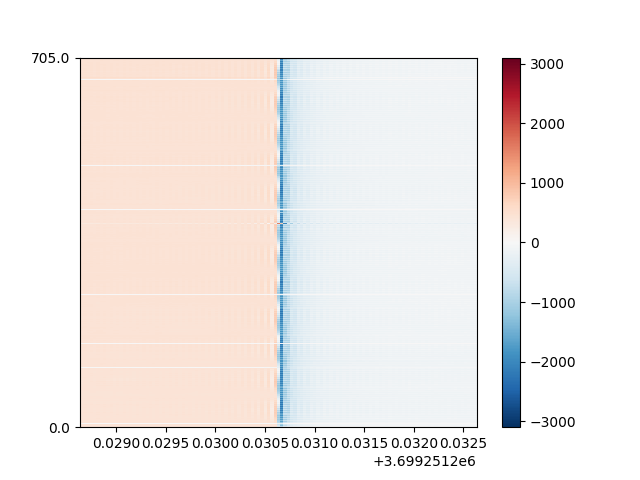

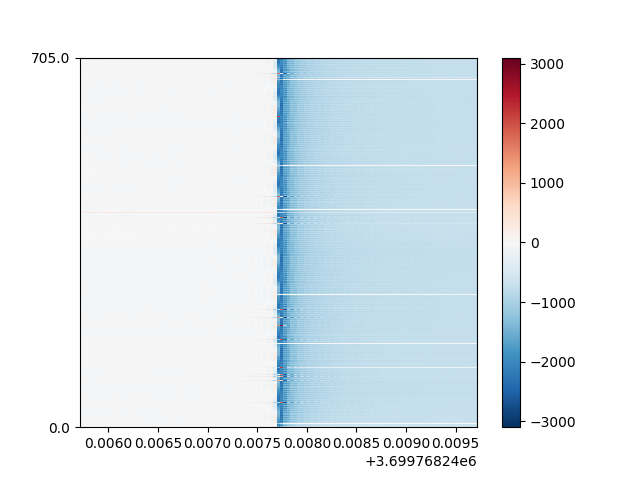

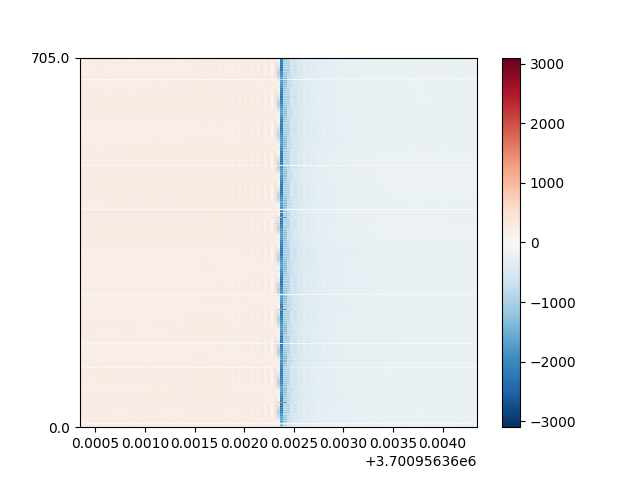

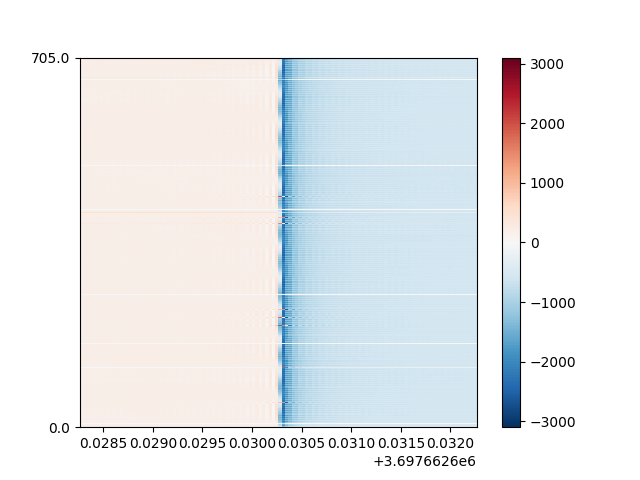

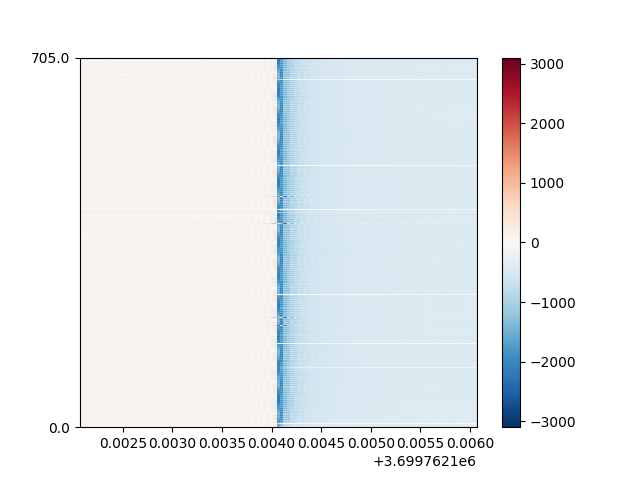

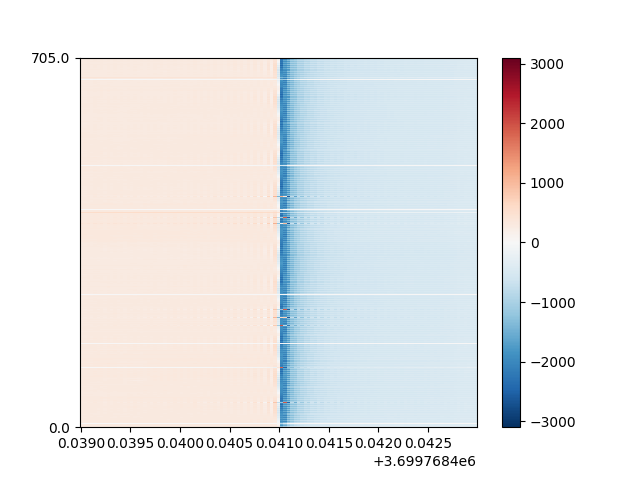

In [35]:
clim = saturation_threshold_uv / 2

if len(pos_evts) > 0:
    print(f"Found {len(pos_evts)} positive saturation events!")
    random_saturation_events = pos_evts[
        np.random.choice(np.arange(len(pos_evts)), size=num_events_to_plot, replace=False)
    ]
    random_saturation_events = random_saturation_events[np.argsort(random_saturation_events["sample_index"])]
    for r in random_saturation_events:
        t0 = recording.sample_index_to_time(r["sample_index"])
        w = sw.plot_traces(recording_ps, time_range=[t0 - t_cutout_s, t0 + t_cutout_s], clim=(-clim, clim))
else:
    print("No positive saturation events found")
if len(neg_evts) > 0:
    print(f"Found {len(neg_evts)} negative saturation events!")
    random_saturation_events = neg_evts[
        np.random.choice(np.arange(len(neg_evts)), size=num_events_to_plot, replace=False)
    ]
    random_saturation_events = random_saturation_events[np.argsort(random_saturation_events["sample_index"])]
    for r in random_saturation_events:
        t0 = recording.sample_index_to_time(r["sample_index"])
        sw.plot_traces(recording_ps, time_range=[t0 - t_cutout_s, t0 + t_cutout_s], clim=(-clim, clim))
else:
    print("No negative saturation events found")

In [36]:
random_saturation_events["channel_index"]

array([11, 11, 25])

## Event artifacts

In [7]:
harp_folder = [p for p in (raw_asset_folder / "behavior").glob("**/raw.harp")]
if len(harp_folder) == 1:
    harp_folder = harp_folder[0]
    print("Harp folder found")
    event_json_files = [p for p in harp_folder.parent.iterdir() if p.suffix == ".json"]
    if len(event_json_files) == 1:
        print("HARP event json file found!")
        event_json_file = event_json_files[0]
        with open(event_json_file) as f:
            event_dict = json.load(f)

Harp folder found
HARP event json file found!


In [8]:
keywords = ["licktime", "optogeneticstime"]

In [9]:
unit_dict = {}
for k in event_dict.keys():
    if any(keyword in k.lower() for keyword in keywords):
        events = event_dict[k]
        if len(events) > 0:
            sample_indices = raw_recording.time_to_sample_index(event_dict[k])
            unit_dict[k] = sample_indices
sorting_events = si.NumpySorting.from_unit_dict([unit_dict], sampling_frequency=raw_recording.sampling_frequency)

In [10]:
sorting_events

NumpySorting: 2 units - 1 segments - 30.0kHz

In [11]:
analyzer = si.create_sorting_analyzer(sorting_events, raw_recording, sparse=False)

In [12]:
extensions = {
    "random_spikes": {"method": "all"},
    "templates": {"ms_before": 10, "ms_after": 10},
}

In [13]:
analyzer.compute(extensions, chunk_duration="1s")

/opt/conda/lib/python3.9/site-packages/spikeinterface/core/job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


estimate_templates_with_accumulator:   0%|          | 0/5474 [00:00<?, ?it/s]

In [14]:
sw.plot_unit_templates(analyzer, backend="ipywidgets")

/opt/conda/lib/python3.9/site-packages/spikeinterface/widgets/unit_waveforms.py:182: UserWarning: templates_percentile_shading can only be used if the 'waveforms' extension is available. Settimg templates_percentile_shading to None.
  warn(


AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

In [50]:
template_ext = analyzer.get_extension("templates")
templates = template_ext.get_data()

In [43]:
import matplotlib as mpl

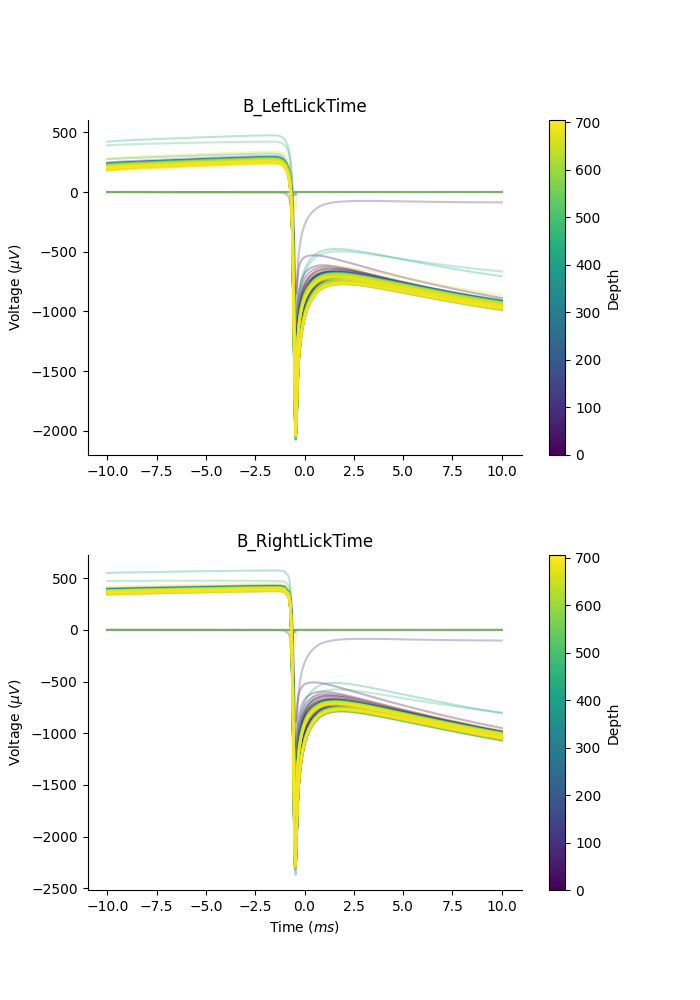

In [56]:
fig, axs = plt.subplots(nrows=len(analyzer.unit_ids), figsize=(7, 10))
for unit_index, unit_id in enumerate(analyzer.unit_ids):
    ax = axs[unit_index]
    # color by depth
    cmap = plt.get_cmap("viridis", analyzer.get_num_channels())
    depths = analyzer.get_channel_locations()[:, 1]
    norm = mpl.colors.Normalize(vmin=np.min(depths), vmax=np.max(depths))

    colors = cmap(np.arange(analyzer.get_num_channels()))
    times = np.linspace(-template_ext.params["ms_before"], template_ext.params["ms_after"], templates.shape[1])

    for template, color in zip(templates[unit_index].T, colors):
        ax.plot(times, template, color=color, alpha=0.3)

    ax.set_title(unit_id)
    ax.set_ylabel("Voltage ($\\mu V$)")
    if unit_index == analyzer.get_num_units() - 1:
        ax.set_xlabel("Time ($ms$)")
    ax.spines[["top", "right"]].set_visible(False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 ax=ax, orientation='vertical', label='Depth')
fig.subplots_adjust(hspace=0.3)